In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

import sys


sys.path.append('../..')
sys.path.append('../')

import optimneuralts
import viz_config
from utils import *


saves_path = '../saves'
%load_ext autoreload
%autoreload 2

/home/quo/Documents/Maitrise/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
experiments = [
    "50_rx_100000_combis_4_patterns_42",
    "100_rx_100000_combis_10_patterns_42",
    "100_rx_100000_combis_10_patterns_42_0.1expl",
    "100_rx_100000_combis_10_patterns_42_0.5expl",
    "100_rx_100000_combis_10_patterns_42_0.9expl",
    # "100_rx_100000_combis_10_patterns_42_2layers",
    # "100_rx_100000_combis_12_patterns_10_percent_42",
]
n_trials = 10000
n_runs = 25
metrics_dict = {}
metrics = ["jaccards", "ratio_apps", "ratio_found_pats", "losses", "dataset_losses"]

for exp in experiments:
    metrics_dict[exp] = {}
    for metric in metrics:
        metrics_dict[exp][metric] = []
        for run in range(n_runs):
            path = f"{saves_path}/{exp}/{metric}/{run}.pth"
            metrics_dict[exp][metric].append(torch.load(path))


In [3]:
colors = ["tab:orange", "tab:purple", "tab:green", "tab:red", "tab:cyan", "tab:brown"]
labels = experiments
interval = 100
upper_lim = 20100


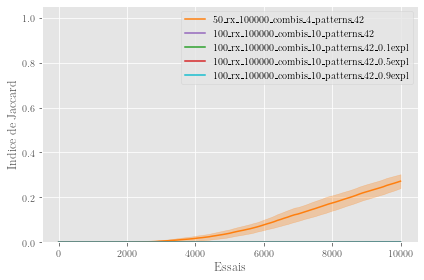

In [4]:
metric = "jaccards"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )
    plt.xlabel("Essais")
    plt.ylabel("Indice de Jaccard")
plt.legend()
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()
# plt.savefig(f'../images/exp_poly/perf/')


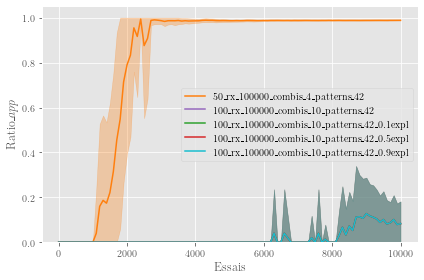

In [5]:
metric = "ratio_apps"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )
    plt.xlabel("Essais")
    plt.ylabel("Ratio_${app}$")
plt.legend()
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()
# plt.savefig(f'../images/exp_poly/perf/')


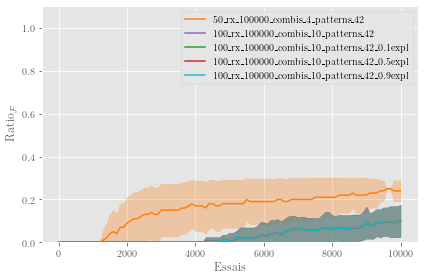

In [6]:
# Plot ratio found pat
metric = "ratio_found_pats"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval


    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Ratio$_{\mathcal{F}}$")
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()


# plt.savefig(f'../images/exp_poly/perf/compare_density_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')


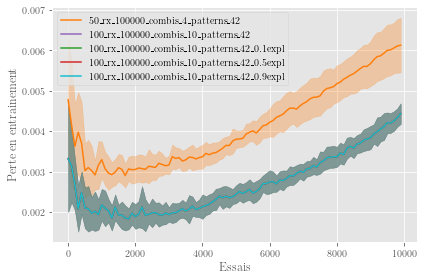

In [7]:
# Plot ratio found pat
metric = "losses"
for i, exp in enumerate(experiments):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte en entrainement")
plt.legend()
plt.tight_layout()

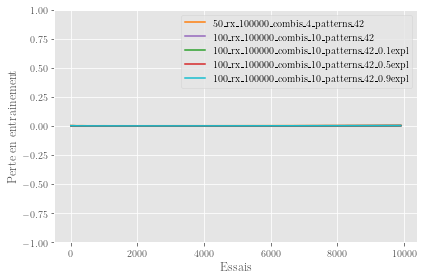

In [8]:
# Plot ratio found pat
metric = "losses"
for i, exp in enumerate(experiments):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte en entrainement")
plt.legend()
plt.ylim(-1, 1)
plt.tight_layout()

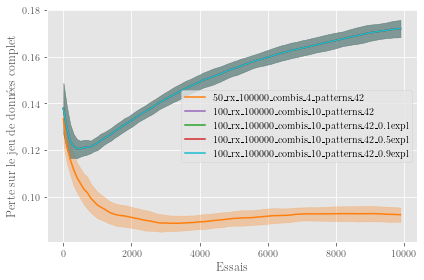

In [9]:
# Plot ratio found pat
metric = "dataset_losses"

for i, exp in enumerate(experiments):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte sur le jeu de données complet")
plt.legend()
plt.tight_layout()

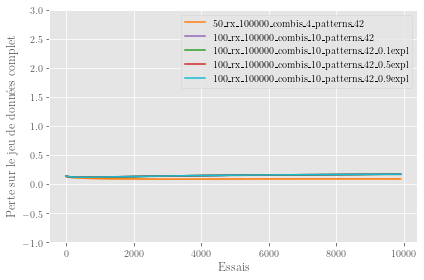

In [10]:
# Plot ratio found pat
metric = "dataset_losses"

for i, exp in enumerate(experiments):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte sur le jeu de données complet")
plt.legend()
plt.ylim(-1, 3)
plt.tight_layout()